# Voice Inpainting Debug Demo

In [1]:
import os
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
import time
from loguru import logger

from src.tokenization import AudioTokenizer
from src.semantic_edit import SemanticEditor, EditOperation
from src.generation import TokenGenerator
from src.fusion import TokenFusion, FusionConfig, FusionMethod
from src.main import voice_inpainting_unified, setup_device

%load_ext autoreload
%autoreload 2

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/Users/philipp/Documents/audio-inpaint/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Input parameters
input_file = "data/debug/2739d072-86c9-4606-9618-3f452716ebac/01_original.wav"
edit_prompt = "Change 'one piece' to 'two pieces'"
output_file = "output.wav"
debug_dir = "data/debug_output"

# Create debug directory
os.makedirs(debug_dir, exist_ok=True)

In [3]:
# Display original audio
waveform, sample_rate = torchaudio.load(input_file)
print(f"Original Audio: {input_file}")
display(Audio(waveform, rate=sample_rate))

# Run voice inpainting
fused_tokens, final_audio, final_sr = voice_inpainting_unified(
    input_file=input_file,
    output_file=output_file,
    edits=edit_prompt,
    fusion_method="contextual",
    debug=True,
    debug_dir=debug_dir,
    temperature=0.7,
    topk=30
)

Original Audio: data/debug/2739d072-86c9-4606-9618-3f452716ebac/01_original.wav


2025-03-29 14:28:00.185 | INFO     | src.main:voice_inpainting_unified:75 - Debug mode enabled. Intermediate files will be saved to data/debug_output
2025-03-29 14:28:00.199 | WARNING  | src.main:setup_device:35 - MPS backend detected but not used due to compatibility issues with sparse tensors. Falling back to CPU. This will be slower but more reliable.
2025-03-29 14:28:00.200 | INFO     | src.main:setup_device:41 - Using device: cpu
2025-03-29 14:28:00.200 | INFO     | src.main:voice_inpainting_unified:84 - Tokenizing input audio to RVQ tokens...
2025-03-29 14:28:00.200 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 14:28:00.312 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 14:28:00.312 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 14:28:00.507 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating

import error: No module named 'triton'


2025-03-29 14:38:54.472 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 14:38:54.476 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 14:38:54.653 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codebooks
2025-03-29 14:38:54.696 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:57 - Warming up MLX models
2025-03-29 14:38:57.612 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:61 - moshi_mlx initialization complete


ckpt path or config path does not exist! Downloading the model from the Hugging Face Hub...


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 31033.55it/s]
2025-03-29 14:38:58.618 | INFO     | src.generation:_initialize_csm_model:55 - CSM model loaded successfully
2025-03-29 14:38:58.619 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 14:38:58.619 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 14:38:58.620 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 14:38:58.753 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codebooks
2025-03-29 14:38:58.786 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:57 - Warming up MLX models
2025-03-29 14:38:58.948 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:61 - moshi_mlx initialization complete
2025-03-29 14:38:58.949 | INFO     | src.tokenization:_initialize_tokenizers:76 - Initializing Llama text tokenizer...


In [7]:
fusion_method = "crossfade"
debug = True
debug_dir  = "data/debug_output"
temperature = 0.7
topk = 30
fusion_method = "crossfade"
edits = edit_prompt
debug = True
debug_dir  = "data/debug_output"
temperature = 0.7
topk = 30

start_time = time.time()

# Create debug directory if debug mode is enabled
if debug:
    logger.info(
        f"Debug mode enabled. Intermediate files will be saved to {debug_dir}"
    )
    os.makedirs(debug_dir, exist_ok=True)

# Set up device
device = setup_device()

# Step 1: Tokenize input audio to RVQ tokens
logger.info("Tokenizing input audio to RVQ tokens...")
tokenizer = AudioTokenizer(device=device)
tokenized_audio = tokenizer.tokenize(input_file)

if debug:
    # Save original audio for reference
    torchaudio.save(
        os.path.join(debug_dir, "01_original.wav"),
        tokenized_audio.audio.unsqueeze(0),
        tokenized_audio.sample_rate,
    )

    # Also save transcription
    with open(os.path.join(debug_dir, "02_transcription.txt"), "w") as f:
        f.write(f"Original transcription: {tokenized_audio.text}\n")

# Step 2: Process the edits - either convert a single prompt to an edit operation
#         or use the provided list of edits
edit_operations = []

# Single edit prompt provided - use SemanticEditor to find edit region
logger.info(f"Processing single edit prompt: {edits}")
editor = SemanticEditor(tokenizer, load_llm=True)
edit_op = editor.find_edit_region(tokenized_audio, edits)
edit_operations.append(edit_op)

if debug:
    with open(os.path.join(debug_dir, "03_edit_region.txt"), "w") as f:
        f.write(f"Edit prompt: {edits}\n")
        f.write(f"Original text: '{edit_op.original_text}'\n")
        f.write(f"Edited text: '{edit_op.edited_text}'\n")
        f.write(
            f"Token range: {edit_op.start_token_idx} to {edit_op.end_token_idx}\n"
        )
        if edit_op.prepadding_text:
            f.write(f"Pre-padding: '{edit_op.prepadding_text}'\n")
        if edit_op.postpadding_text:
            f.write(f"Post-padding: '{edit_op.postpadding_text}'\n")

2025-03-29 14:22:54.341 | INFO     | __main__:<module>:17 - Debug mode enabled. Intermediate files will be saved to data/debug_output
2025-03-29 14:22:54.341 | WARNING  | src.main:setup_device:35 - MPS backend detected but not used due to compatibility issues with sparse tensors. Falling back to CPU. This will be slower but more reliable.
2025-03-29 14:22:54.342 | INFO     | src.main:setup_device:41 - Using device: cpu
2025-03-29 14:22:54.342 | INFO     | __main__:<module>:26 - Tokenizing input audio to RVQ tokens...
2025-03-29 14:22:54.342 | INFO     | src.tokenization:_initialize_tokenizers:71 - Initializing Mimi RVQ tokenizer...
2025-03-29 14:22:54.342 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:38 - Initializing moshi_mlx backend
2025-03-29 14:22:54.342 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:41 - Downloading moshi_mlx tokenizer weights
2025-03-29 14:22:54.477 | INFO     | src.mimi_tokenizer:_initialize_moshi_mlx:47 - Creating Mimi MLX models with 32 codeboo

KeyboardInterrupt: 

In [179]:
# Find the token range for the edit
# First locate the text indices
try:
    start_char_idx = text.index(subseq_original)
    end_char_idx = start_char_idx + len(subseq_original)
except ValueError:
    logger.warning(
        f"Could not find '{subseq_original}' in text, using fuzzy matching"
    )
    start_char_idx, end_char_idx = editor._fuzzy_find_substring(
        text, subseq_original
    )

# Now map the character indices to token indices
# Use text_to_token_map from the tokenized audio
start_token_idx, end_token_idx = editor.tokenizer.find_token_range(
    tokenized_audio, (start_char_idx, end_char_idx)
)

edit_op = EditOperation(
    original_text=subseq_original,
    edited_text=subseq_edited,
    start_token_idx=start_token_idx,
    end_token_idx=end_token_idx,
)

# Calculate time range for the edit
token_frame_rate = 12.5  # frames per second
start_time_sec = edit_op.start_token_idx / token_frame_rate
end_time_sec = edit_op.end_token_idx / token_frame_rate

if debug:
    with open(os.path.join(debug_dir, "03_edit_region.txt"), "w") as f:
        f.write(f"Edit prompt: {edit_prompt}\n")
        f.write(f"Original text: '{edit_op.original_text}'\n")
        f.write(f"Edited text: '{edit_op.edited_text}'\n")
        f.write(
            f"Token range: {edit_op.start_token_idx} to {edit_op.end_token_idx}\n"
        )
        f.write(f"Time range: {start_time_sec:.2f}s to {end_time_sec:.2f}s\n")
        f.write(
            f"Edit length: {edit_op.end_token_idx - edit_op.start_token_idx} frames, {end_time_sec - start_time_sec:.2f} seconds\n"
        )

    # Extract and save just the portion to be edited
    with torch.inference_mode():
        edit_tokens = tokenized_audio.rvq_tokens[
            :, edit_op.start_token_idx : edit_op.end_token_idx
        ]
        if edit_tokens.shape[1] > 0:
            edit_audio, edit_sr = tokenizer.reconstruct_audio(edit_tokens)
            edit_path = os.path.join(debug_dir, "03b_original_edit_region.wav")
            torchaudio.save(edit_path, edit_audio.unsqueeze(0), edit_sr)


orig_seg_path = os.path.join(debug_dir, "03b_original_edit_region.wav")
if os.path.exists(orig_seg_path):
    orig_waveform, orig_sr = torchaudio.load(orig_seg_path)
    print("Original Segment:")
    display(Audio(orig_waveform, rate=orig_sr))


2025-03-22 19:30:27.399 | INFO     | src.tokenization:find_token_range:37 - Text range (14, 23) maps to token range [22, 29]
2025-03-22 19:30:27.405 | INFO     | src.tokenization:reconstruct_audio:262 - Reconstructing audio from RVQ tokens...


Original Segment:


In [180]:
# Step 3: Generate new tokens for the edit
logger.info("Generating new tokens for the edited segment...")
generator = TokenGenerator(device=device)

with torch.inference_mode():
    generated_tokens = generator.generate_replacement_tokens(
        tokenized_audio, edit_op, temperature=temperature, topk=topk
    )

if debug:
    # Reconstruct and save just the generated audio
    with torch.inference_mode():
        gen_audio, gen_sr = tokenizer.reconstruct_audio(generated_tokens)
        gen_path = os.path.join(debug_dir, "04_generated_segment.wav")
        torchaudio.save(gen_path, gen_audio.unsqueeze(0), gen_sr)

    with open(os.path.join(debug_dir, "04b_generation_info.txt"), "w") as f:
        f.write(f"Generated tokens shape: {generated_tokens.shape}\n")
        f.write(
            f"Generated duration: {generated_tokens.shape[1] / 12.5:.2f} seconds\n"
        )
        f.write("Generation parameters:\n")
        f.write(f"  Temperature: {temperature}\n")
        f.write(f"  Top-k: {topk}\n")

# Compare original and edited sections
gen_path = os.path.join(debug_dir, "04_generated_segment.wav")
if os.path.exists(gen_path):
    gen_waveform, gen_sr = torchaudio.load(gen_path)
    print("Generated Segment:")
    display(Audio(gen_waveform, rate=gen_sr))


2025-03-22 19:30:27.590 | INFO     | __main__:<module>:2 - Generating new tokens for the edited segment...
2025-03-22 19:30:27.591 | INFO     | src.generation:_initialize_csm_model:49 - Initializing CSM model...


ckpt path or config path does not exist! Downloading the model from the Hugging Face Hub...


Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 143112.73it/s]
2025-03-22 19:31:02.294 | INFO     | src.generation:_initialize_csm_model:58 - CSM model loaded successfully
2025-03-22 19:31:02.295 | INFO     | src.tokenization:_initialize_tokenizers:64 - Initializing Mimi RVQ tokenizer...
2025-03-22 19:31:02.794 | INFO     | src.tokenization:_initialize_tokenizers:70 - Initializing Llama text tokenizer...
2025-03-22 19:31:03.496 | INFO     | src.tokenization:_initialize_tokenizers:73 - Loading Whisper ASR model...
2025-03-22 19:31:04.990 | INFO     | src.generation:generate_replacement_tokens:173 - Generating replacement tokens for: 'cheesecake'
2025-03-22 19:31:04.991 | INFO     | src.tokenization:extract_context_audio:345 - Extracted context audio from -1.24s to 5.32s
2025-03-22 19:31:04.992 | INFO     | src.generation:_prepare_context_segment:115 - Prepared context: 'one piece of [...] please'
2025-03-22 19:31:04.994 | INFO     | src.generation:generate_replacement_tokens:180

Generated Segment:


In [ ]:
context_audio = tokenizer.extract_context_audio(
            tokenized_audio,
            (edit_op.start_token_idx, edit_op.end_token_idx),
        )

In [185]:
# fusion_method = "crossfade"
fusion_method = "contextual"

# Step 4: Fuse tokens
logger.info(f"Fusing tokens using {fusion_method} method...")
fusion_config = FusionConfig(
    method=FusionMethod(fusion_method),
    crossfade_frames=4,
    alpha=0.05,
    decay_factor=0.01,
    use_semantic_preservation=True,
)

fusion = TokenFusion(config=fusion_config)

with torch.inference_mode():
    fused_tokens = fusion.fuse_tokens(
        tokenized_audio.rvq_tokens,
        generated_tokens,
        (edit_op.start_token_idx, edit_op.end_token_idx),
    )

# Step 5: Reconstruct audio from fused tokens
logger.info("Reconstructing audio from fused tokens...")
with torch.inference_mode():
    final_audio, final_sr = tokenizer.reconstruct_audio(fused_tokens)

# Save the result
out_dir = os.path.dirname(output_file)
if out_dir and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

logger.info(f"Saving final audio to {output_file}")
torchaudio.save(output_file, final_audio.unsqueeze(0), final_sr)

if debug:
    # Also save a debug copy
    debug_output = os.path.join(debug_dir, "05_final_result.wav")
    torchaudio.save(debug_output, final_audio.unsqueeze(0), final_sr)

    # Save fusion information
    with open(os.path.join(debug_dir, "06_fusion_info.txt"), "w") as f:
        f.write(f"Fusion method: {fusion_method}\n")
        f.write(f"Original tokens shape: {tokenized_audio.rvq_tokens.shape}\n")
        f.write(f"Generated tokens shape: {generated_tokens.shape}\n")
        f.write(f"Fused tokens shape: {fused_tokens.shape}\n")
        f.write(f"Final duration: {fused_tokens.shape[1] / 12.5:.2f} seconds\n")

elapsed_time = time.time() - start_time
logger.info(
    f"Voice inpainting completed successfully in {elapsed_time:.2f} seconds"
)

# Display edited audio
print(f"Edited Audio: {output_file}")
display(Audio(final_audio, rate=final_sr))

2025-03-22 19:34:41.263 | INFO     | __main__:<module>:5 - Fusing tokens using contextual method...
2025-03-22 19:34:41.289 | INFO     | src.fusion:fuse_tokens:121 - Fused tokens with method: contextual
2025-03-22 19:34:41.290 | INFO     | __main__:<module>:24 - Reconstructing audio from fused tokens...
2025-03-22 19:34:41.291 | INFO     | src.tokenization:reconstruct_audio:262 - Reconstructing audio from RVQ tokens...
2025-03-22 19:34:41.303 | INFO     | __main__:<module>:33 - Saving final audio to output.wav
2025-03-22 19:34:41.309 | INFO     | __main__:<module>:50 - Voice inpainting completed successfully in 308.98 seconds


Edited Audio: output.wav


In [184]:
# Show debug information
def print_debug_file(filename):
    path = os.path.join(debug_dir, filename)
    if os.path.exists(path):
        print(f"\n=== {filename} ===")
        with open(path, 'r') as f:
            print(f.read())

print_debug_file("02_tokenization.txt")
print_debug_file("03_edit_region.txt")
print_debug_file("04b_generation_info.txt")
print_debug_file("06_fusion_info.txt")


=== 02_tokenization.txt ===
RVQ Tokens shape: torch.Size([32, 43])
Frame rate: 12.5 Hz (80ms per frame)
Duration: 3.44 seconds
Extracted text:  one piece of chocolate please
Speaker ID: 0

Word timestamps from Whisper:
0: ' one' (0.00s - 0.96s)
1: ' piece' (0.96s - 1.38s)
2: ' of' (1.38s - 1.74s)
3: ' chocolate' (1.74s - 2.12s)
4: ' please' (2.12s - 2.56s)


=== 03_edit_region.txt ===
Edit prompt: Change 'chocolate' to 'cheesecake'
Original text: 'chocolate'
Edited text: 'cheesecake'
Token range: 22 to 29
Time range: 1.76s to 2.32s
Edit length: 7 frames, 0.56 seconds


=== 04b_generation_info.txt ===
Generated tokens shape: torch.Size([32, 9])
Generated duration: 0.72 seconds
Generation parameters:
  Temperature: 0.7
  Top-k: 30


=== 06_fusion_info.txt ===
Fusion method: crossfade
Original tokens shape: torch.Size([32, 43])
Generated tokens shape: torch.Size([32, 9])
Fused tokens shape: torch.Size([32, 45])
Final duration: 3.60 seconds



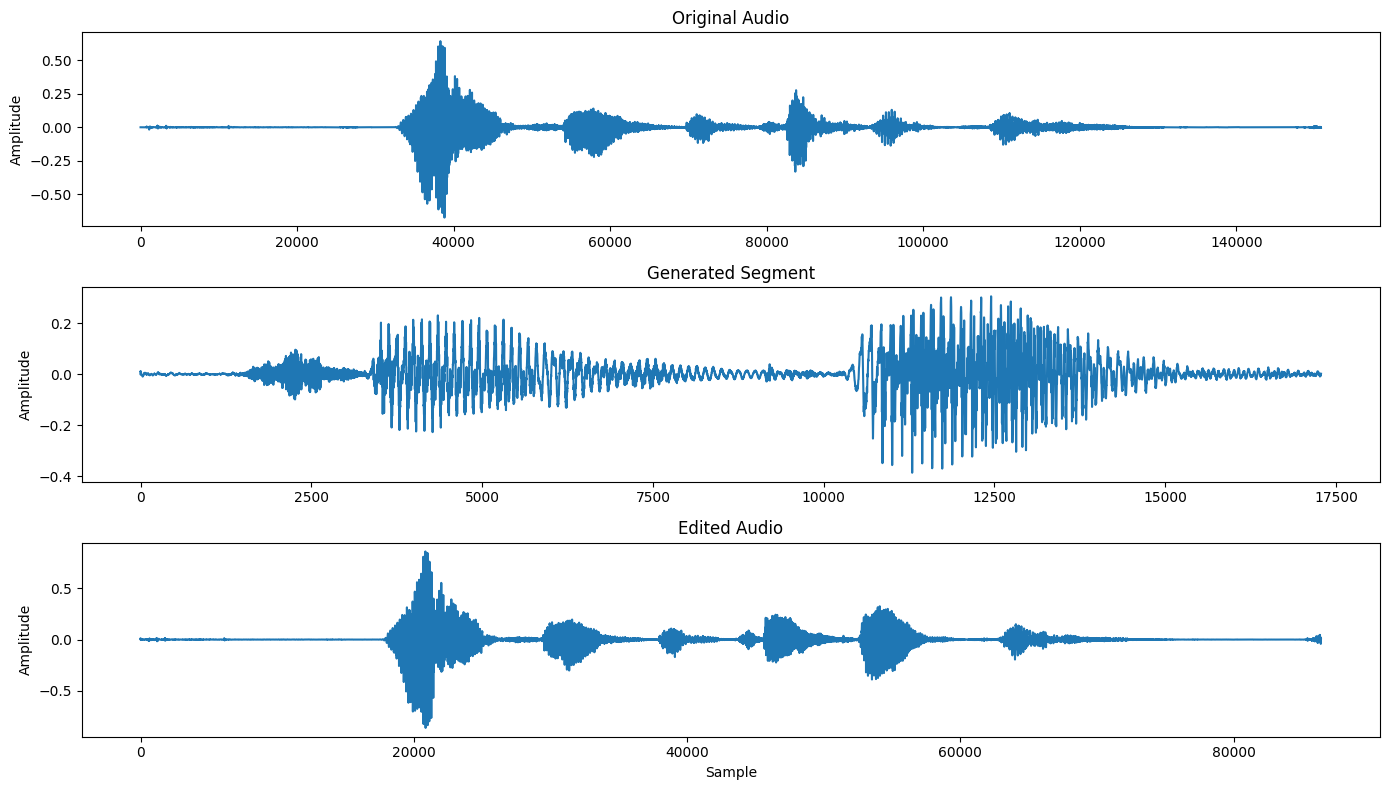

In [183]:
# Plot waveforms for comparison
plt.figure(figsize=(14, 8))

# Original audio
plt.subplot(3, 1, 1)
plt.plot(waveform[0].numpy())
plt.title("Original Audio")
plt.ylabel("Amplitude")

# Edited audio
plt.subplot(3, 1, 3)
plt.plot(final_audio.numpy())
plt.title("Edited Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

# Generated segment
if os.path.exists(gen_path):
    plt.subplot(3, 1, 2)
    plt.plot(gen_waveform[0].numpy())
    plt.title("Generated Segment")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()